In [27]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [28]:
df = pd.read_csv('Test3_Full_Original.csv',
            delimiter=',', names=['x', 'y', 'Magicv2', 'localization4', 'localizationlab', 'Magicv2_5g', 'UVIC_Eduroam1', 'UVIC_Eduroam2', 'localization3', 'localization_lab5g', 'localization1', 'localization4_5g', 'UVIC_Eduroam3', 'localization2', 'localization3_5g', 'UVIC_Eduroam4', 'localization1_5g'])
df = df.loc[:,['x','y','Magicv2', 'localization4', 'localizationlab', 'Magicv2_5g', 
       'localization3', 'localization_lab5g', 'localization1', 'localization4_5g', 'localization2',
       'localization3_5g', 'localization1_5g']]

df['Average'] = (df.Magicv2 + df.localization4 + df.localizationlab + df.Magicv2_5g + df.localization3 + df.localization_lab5g + df.localization1 + df.localization4_5g + df.localization2 + df.localization3_5g + df.localization1_5g)/11

In [39]:
X = df.drop('Average', axis = 1)
y = df[['Average']]

In [40]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [41]:
print("X_train:",x_train.shape)
print("X_test:", x_test.shape)
print("Y_train:", y_train.shape)
print("Y_test:", y_test.shape)

X_train: (496, 13)
X_test: (124, 13)
Y_train: (496, 1)
Y_test: (124, 1)


In [42]:
# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(x_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(x_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(x_test)

In [43]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (94, 30, 13)
y_train.shape:  (466, 1)
X_test.shape:  (94, 30, 13)
y_test.shape:  (466, 1)


In [44]:
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model

In [45]:
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [46]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

In [47]:
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Train on 372 samples, validate on 94 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
372/372 [==============================] - 4s 10ms/sample - loss: 0.0911 - val_loss: 0.0083
Epoch 2/100
372/372 [==============================] - 0s 925us/sample - loss: 0.0310 - val_loss: 0.0148
Epoch 3/100
372/372 [==============================] - 0s 1ms/sample - loss: 0.0184 - val_loss: 0.0134
Epoch 4/100
372/372 [==============================] - 0s 967us/sample - loss: 0.0130 - val_loss: 0.0185
Epoch 5/100
372/372 [==============================] - 0s 887us/sample - loss: 0.0116 - val_loss: 0.0176
Epoch 6/100
372/372 [==============================] - 0s 1ms/sample - loss: 0.0094 - val_loss: 0.0196
Epoch 7/100
372/372 [==============================] - 0s 1ms/sample - loss: 0.0102 - val_loss: 0.0188
Epoch 8/100
372/372 [==============================] - 0s 881us/sample - loss: 0.0092 - val_loss: 0.0209
Epoch 9/100
372/372 [=======

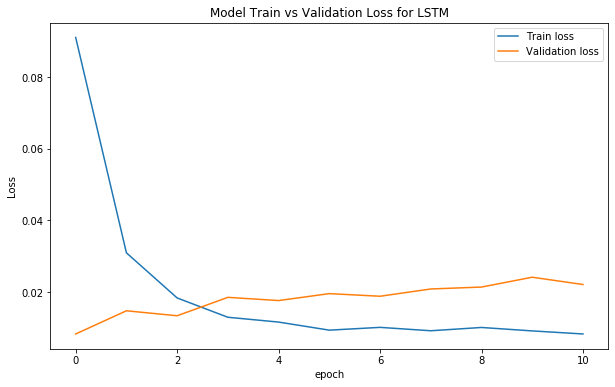

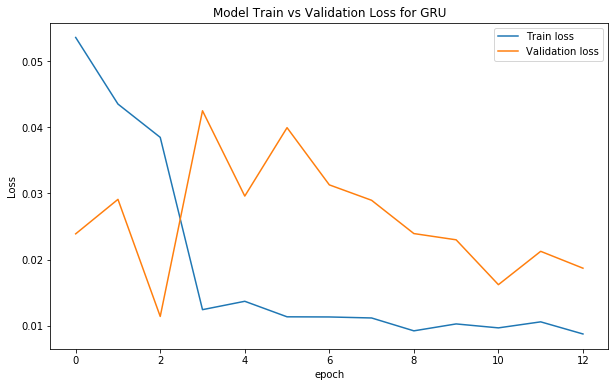

In [48]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/loss_'+model_name+'.jpg', format='jpg', dpi=1000)


plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [49]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [50]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

In [51]:
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

In [52]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
    #plt.savefig('C:/Users/nious/Documents/Medium/LSTM&GRU/predic_'+model_name+'.jpg', format='jpg', dpi=1000)

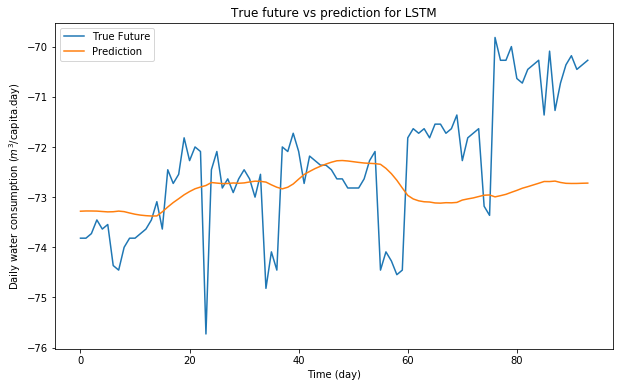

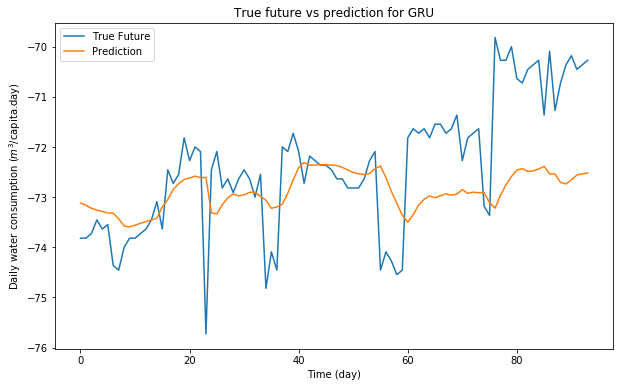

In [53]:
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [54]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

LSTM:
Mean Absolute Error: 1.0688
Root Mean Square Error: 1.3724

GRU:
Mean Absolute Error: 0.9912
Root Mean Square Error: 1.2852

